In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from helper import convert_to_time

## LOAD THE DATA

In [3]:
np.random.seed(1)

# Default values
filename = 'TOTAL_KSI_6386614326836635957.csv'
input_directory = '../data/'
output_directory = './output/'

ksi_df = pd.read_csv(f'{input_directory}{filename}')


In [4]:
print(ksi_df.describe())


           OBJECTID         INDEX        ACCNUM          TIME      LATITUDE  \
count  18957.000000  1.895700e+04  1.402700e+04  18957.000000  18957.000000   
mean    9479.000000  3.994181e+07  5.576714e+08   1364.956428     43.710299   
std     5472.558862  3.749731e+07  1.180026e+09    631.310388      0.056294   
min        1.000000  3.363207e+06  2.530100e+04      0.000000     43.589678   
25%     4740.000000  5.408154e+06  1.034561e+06    924.000000     43.661727   
50%     9479.000000  7.820656e+06  1.220029e+06   1450.000000     43.702346   
75%    14218.000000  8.092292e+07  1.386958e+06   1852.000000     43.755945   
max    18957.000000  8.180752e+07  4.008024e+09   2359.000000     43.855445   

          LONGITUDE    FATAL_NO              x             y  
count  18957.000000  870.000000   18957.000000  1.895700e+04  
mean     -79.396490   28.752874  629181.568576  4.840951e+06  
std        0.104484   17.657001    8364.337712  6.324585e+03  
min      -79.638390    1.000000  609

In [5]:
print(ksi_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18957 entries, 0 to 18956
Data columns (total 54 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OBJECTID           18957 non-null  int64  
 1   INDEX              18957 non-null  int64  
 2   ACCNUM             14027 non-null  float64
 3   DATE               18957 non-null  object 
 4   TIME               18957 non-null  int64  
 5   STREET1            18957 non-null  object 
 6   STREET2            17251 non-null  object 
 7   OFFSET             3820 non-null   object 
 8   ROAD_CLASS         18471 non-null  object 
 9   DISTRICT           18728 non-null  object 
 10  LATITUDE           18957 non-null  float64
 11  LONGITUDE          18957 non-null  float64
 12  ACCLOC             13501 non-null  object 
 13  TRAFFCTL           18882 non-null  object 
 14  VISIBILITY         18933 non-null  object 
 15  LIGHT              18953 non-null  object 
 16  RDSFCOND           189

In [6]:
print(ksi_df.isnull().sum())

OBJECTID                 0
INDEX                    0
ACCNUM                4930
DATE                     0
TIME                     0
STREET1                  0
STREET2               1706
OFFSET               15137
ROAD_CLASS             486
DISTRICT               229
LATITUDE                 0
LONGITUDE                0
ACCLOC                5456
TRAFFCTL                75
VISIBILITY              24
LIGHT                    4
RDSFCOND                29
ACCLASS                  1
IMPACTYPE               27
INVTYPE                 16
INVAGE                   0
INJURY                8897
FATAL_NO             18087
INITDIR               5277
VEHTYPE               3487
MANOEUVER             7953
DRIVACT               9289
DRIVCOND              9291
PEDTYPE              15728
PEDACT               15730
PEDCOND              15711
CYCLISTYPE           18152
CYCACT               18155
CYCCOND              18157
PEDESTRIAN           11269
CYCLIST              16971
AUTOMOBILE            1727
M

In [7]:
ksi_df.head(3)

,OBJECTID,INDEX,ACCNUM,DATE,TIME,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,REDLIGHT,ALCOHOL,DISABILITY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,DIVISION,x,y
0,1,3389067,893184.0,1/1/2006 10:00:00 AM,236,WOODBINE AVE,O CONNOR DR,NaN,Major Arterial,Toronto and East York,...,NaN,Yes,NaN,60,Woodbine-Lumsden,60,Woodbine-Lumsden (60),D55,635468.3685,4.839881e+06
1,2,3389068,893184.0,1/1/2006 10:00:00 AM,236,WOODBINE AVE,O CONNOR DR,NaN,Major Arterial,Toronto and East York,...,NaN,Yes,NaN,60,Woodbine-Lumsden,60,Woodbine-Lumsden (60),D55,635468.3685,4.839881e+06
2,3,3389069,893184.0,1/1/2006 10:00:00 AM,236,WOODBINE AVE,O CONNOR DR,NaN,Major Arterial,Toronto and East York,...,NaN,Yes,NaN,60,Woodbine-Lumsden,60,Woodbine-Lumsden (60),D55,635468.3685,4.839881e+06


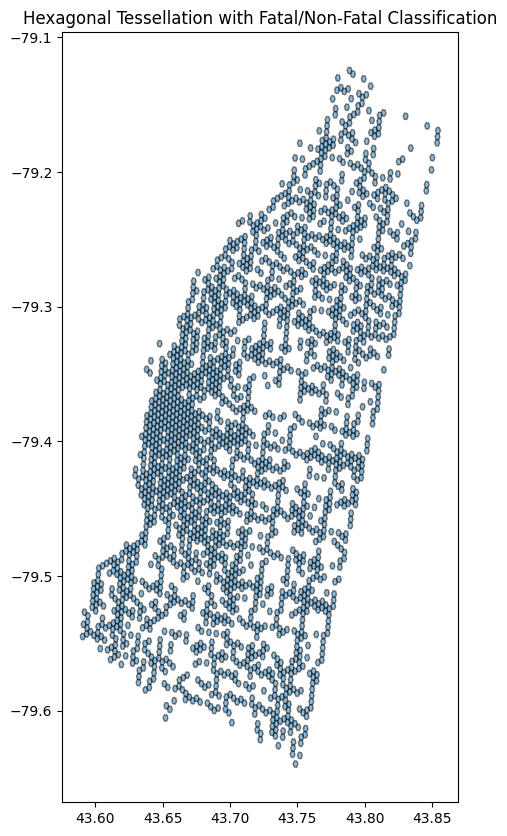

In [24]:
import geopandas as gpd
import pandas as pd
import h3
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon


# Convert data to a GeoDataFrame
df = pd.DataFrame(ksi_df)
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Step 1: Generate Hexagonal Tessellation using H3
resolution = 9  # H3 resolution (adjust for hexagon size)
hexagons = gdf['geometry'].apply(
    lambda x: h3.latlng_to_cell(x.y, x.x, resolution)
)

# Convert H3 hexagons to polygons for visualization
def h3_to_polygon(h3_index):
    boundary = h3.cell_to_boundary(h3_index)
    return Polygon(boundary)

gdf['Hexagon'] = hexagons
gdf['Hexagon_Polygon'] = gdf['Hexagon'].apply(h3_to_polygon)

# Step 2: Aggregate Data by Hexagon
hex_gdf = gdf.groupby('Hexagon').agg({
    'ACCLASS': lambda x: ', '.join(x),
    'Hexagon_Polygon': 'first'
}).reset_index()

# Create GeoDataFrame for hexagons
hex_gdf = gpd.GeoDataFrame(hex_gdf, geometry='Hexagon_Polygon')

# Step 3: Visualization
fig, ax = plt.subplots(figsize=(10, 10))
hex_gdf.plot(ax=ax, edgecolor='black', alpha=0.5)
gdf.plot(ax=ax, c=gdf['ACCLASS'].map({'Fatal': 'red', 'Non-Fatal Injury': 'green'}), markersize=10)
plt.title("Hexagonal Tessellation with Fatal/Non-Fatal Classification")
plt.show()


In [8]:
dropped_fields = [
    'INDEX',
    'ACCNUM',
    'OBJECTID',
    'STREET1',
    'STREET2',
    'DISTRICT',
    'LATITUDE',
    'LONGITUDE',
    'ACCLOC',
    'INVTYPE',
    'INVAGE',
    'INJURY',
    'OFFSET',
    'FATAL_NO',
    #'VEHTYPE',
    'INITDIR',
    'MANOEUVER',
    'DRIVACT',
    'DRIVCOND',
    'PEDTYPE',
    'PEDACT',
    'PEDCOND',
    'CYCLISTYPE',
    'CYCACT',
    'CYCCOND',
    'HOOD_158',
    'HOOD_140',
    'NEIGHBOURHOOD_140',
    'DIVISION',
    'x',
    'y',
]

In [9]:
categorical_columns = ksi_df.select_dtypes(include=[object, 'category']).columns.tolist()
numerical_columns = ksi_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Change all values to UpperCase
ksi_df[categorical_columns] = ksi_df[categorical_columns].apply(lambda col: col.str.upper())

#ksi_df.drop(['TIME'], inplace=True)


# Fields to be dropped depending on the dataset
#ksi_df.drop(dropped_fields, axis=1, inplace=True)

# Team agreed to drop the entry with missing label
ksi_df.dropna(subset=['ACCLASS'], inplace=True)

# Dropped ACCLASS with Property Damage : 10 Entries in the dataset 
#ksi_df.drop(ksi_df[ksi_df['ACCLASS'] == 'PROPERTY DAMAGE O'].index, inplace=True)
ksi_df['DATE'] = pd.to_datetime(ksi_df['DATE']).dt.month # Update date to per month
#ksi_df['DATE'] = pd.to_datetime(ksi_df['DATE'], format='%Y-%m')
ksi_df['TIME'] = ksi_df['TIME'].apply(convert_to_time)
ksi_df['TIME'] = pd.to_datetime(ksi_df['TIME']).dt.hour # Update time to per hour
ksi_df['ROAD_CLASS'] = ksi_df['ROAD_CLASS'].str.replace(r'MAJOR ARTERIAL ', 'MAJOR ARTERIAL', regex=False) # Update the incorrect Road Class with space

# Pedestrian and Passenger falls under 'Other' in INVTYPE
#df['VEHTYPE'] = np.where(((df['INVTYPE'] == 'Pedestrian') | (df['INVTYPE'] == 'Passenger')) & (df['VEHTYPE'] != '') , 'Other', df['INVTYPE'])

# Fill in empty fields for boolean columns
boolean_columns = [
    'PEDESTRIAN',
    'CYCLIST',
    'AUTOMOBILE',
    'MOTORCYCLE',
    'TRUCK',
    'TRSN_CITY_VEH',
    'EMERG_VEH',
    'PASSENGER',
    'SPEEDING',
    'AG_DRIV',
    'REDLIGHT',
    'ALCOHOL',
    'DISABILITY'
]
unknown_column = [
'VEHTYPE',
'TRAFFCTL'
]

other_column =  [
    'ROAD_CLASS',
    'VISIBILITY',
    'LIGHT',
    'RDSFCOND',
    'IMPACTYPE'
]

ksi_df[unknown_column] = ksi_df[unknown_column].fillna('Unknown')
ksi_df[other_column] = ksi_df[other_column].fillna('Other')
ksi_df[boolean_columns] = ksi_df[boolean_columns].fillna('No')

/var/folders/gg/llfmzrv17klb_smsmrvhnkzc0000gn/T/ipykernel_65949/667076471.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ksi_df['TIME'] = pd.to_datetime(ksi_df['TIME']).dt.hour # Update time to per hour


In [10]:
from sklearn.feature_selection import mutual_info_classif  
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from matplotlib.pyplot import figure

features = ksi_df.drop(columns=['ACCLASS'], axis=1)
target = ksi_df['ACCLASS']

# Instantiate SelectKBest with the chi2 scoring function and select top 20 features
k_value = 20
selector = SelectKBest(score_func=mutual_info_classif, k=k_value)

# Fit SelectKBest to the data and transform the feature matrix
X_new = selector.fit_transform(features, target)

# Print the shape of the transformed feature matrix
print(f"Transformed feature matrix shape: {X_new.shape}")

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)
print(f"Indices of selected features: {selected_feature_indices}")

# Get the chi-squared scores for each feature
mi_scores = selector.scores_
print(f"Mutual Information scores for all features: {mi_scores}")


figure(figsize=(12, 8), dpi=80)
importances = mutual_info_classif(features, target)
feat_importances = pd.Series(importances, ksi_df.columns[0:len(ksi_df.columns)-1])
feat_importances.plot(kind='barh', color = 'teal')
plt.show()
#mi_scores = mutual_info_classif(features, target)  
#print("Mutual Information Scores: ", mi_scores)

ValueError: could not convert string to float: 'WOODBINE AVE'

In [ ]:
# Check for variance
from sklearn.feature_selection import VarianceThreshold

# Set the threshold (e.g., 0.1 for this example)
selector = VarianceThreshold(threshold=0.1)

# Fit the selector to your data
selector.fit(features)

# Get the variances of each feature
variances = selector.variances_

# Identify features with low variance
low_variance_features = features.columns[selector.variances_ <= 0.5]

# Print the feature variances
variances

# Print the features with low variance
low_variance_features

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Binary mapping
binary_mapping = {'YES': 1, 'NO': 0}
target_mapping = {'FATAL': 1, 'NON-FATAL INJURY': 0, 'PROPERTY DAMAGE O': 2}
column_binary = [
    'PEDESTRIAN',
    'CYCLIST',
    'AUTOMOBILE',
    'MOTORCYCLE',
    'TRUCK',
    'TRSN_CITY_VEH',
    'EMERG_VEH',
    'PASSENGER',
    'SPEEDING',
    'AG_DRIV',
    'REDLIGHT',
    'ALCOHOL',
    'DISABILITY'
]
column_le = [
    'DATE',
    'ROAD_CLASS',
    'TRAFFCTL',
    'VISIBILITY',
    'LIGHT',
    'RDSFCOND',
    'IMPACTYPE',
    'VEHTYPE',
    'NEIGHBOURHOOD_158',
    'STREET1',
    'STREET2',
    'OFFSET',
    'DISTRICT',
    'ACCLOC',
    'INVTYPE',
    'INVAGE',
    'INJURY',
    'INITDIR',
    'MANOEUVER',
    'DRIVACT',
    'DRIVCOND',
    'PEDTYPE',
    'PEDACT',
    'PEDCOND',
    'CYCLISTYPE',
    'CYCACT',
    'CYCCOND',
    'HOOD_158',
    'HOOD_140',
    'NEIGHBOURHOOD_140',
    'DIVISION'
]

# Apply binary mapping using .loc
for column in column_binary:
    ksi_df[column] = ksi_df[column].map(lambda x: binary_mapping[x.upper()])

ksi_df['ACCLASS'] = ksi_df['ACCLASS'].replace(target_mapping)

le = LabelEncoder()

for column in column_le:
    ksi_df[column] = le.fit_transform(ksi_df
    [column])

In [ ]:
ksi_df['ACCLASS']
ksi_df['ACCLASS'] = ksi_df['ACCLASS'].astype(int)


In [ ]:
'''
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(ksi_df, y=column, hue='ACCLASS')
    #sns.swarmplot(ksi_df, x=column, hue='ACCLASS')
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xscale('log')
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

'''

In [ ]:
ksi_df.dropna(subset=['ACCNUM'], inplace=True)
ksi_df.drop(['FATAL_NO'], axis=1, inplace=True)
ksi_df.drop(['OBJECTID'], axis=1, inplace=True)
ksi_df.drop(['INDEX'], axis=1, inplace=True)
ksi_df.drop(['LATITUDE'], axis=1, inplace=True)
ksi_df.drop(['LONGITUDE'], axis=1, inplace=True)
ksi_df.dropna(how='any', inplace=True)


features = ksi_df.drop(columns=['ACCLASS'], axis=1)
target = ksi_df['ACCLASS']

print(ksi_df.info())

In [ ]:
ksi_df.head(5)

In [ ]:
ksi_df.shape

In [ ]:
features.head(5)

In [ ]:
ksi_df.isnull().sum()

In [ ]:
negative_counts = (ksi_df < 0).sum()
print(negative_counts)


In [ ]:
# Instantiate SelectKBest with the chi2 scoring function and select top 20 features
k_value = 20
selector = SelectKBest(score_func=chi2, k=k_value)

# Fit SelectKBest to the data and transform the feature matrix
X_new = selector.fit_transform(features, target)

# Print the shape of the transformed feature matrix
print(f"Transformed feature matrix shape: {X_new.shape}")

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)
print(f"Indices of selected features: {selected_feature_indices}")

# Get the chi-squared scores for each feature
chi2_scores = selector.scores_
print(f"Chi-squared scores for all features: {chi2_scores}")

In [ ]:
features.columns[selected_feature_indices]